<a href="https://colab.research.google.com/github/andrinur13/kuliah_bigdata/blob/master/FP_1800018190.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Perbandingan Rata-Rata Biaya Asuransi Kesehatan (Insurance) Berdasarkan Jenis Kelamin dan Perilaku Merokok**

Nama  : Andri Nur Hidayatulloh

NIM   : 1800018190 

## **Persiapan Environtment**

In [11]:
! apt-get install openjdk-8-jdk-headless -qq > /dev/null
! wget -q http://www-eu.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
! tar xf spark-2.4.5-bin-hadoop2.7.tgz
! pip install -q findspark
! pip install pyspark_dist_explore

In [12]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [13]:
import findspark
findspark.init("spark-2.4.5-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.sql.functions import col, avg
from matplotlib import pyplot as plt
from pyspark_dist_explore import Histogram, hist

In [14]:
sc = spark.sparkContext
spark = SparkSession(sc)

# Load Dataset

In [15]:
data = spark.read.csv('insurance.csv', header=True, inferSchema=True)
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



Pada dataset insurances tersebut terdapat 7 kolom data yaitu : 



1.   Age (Umur dari pengguna asuransi kesehatan)
2.   Sex (Jenis kelamin dari pengguna asuransi)
3.   BMI (Index masa tubuh)
4.   Children ()
5.   Smoker (perilaku pengguna asuransi apakah merokok atau tidak)
6.   Region (alamat pengguna asuransi)
7.   Charges (biaya asuransi)

Pada kasus kali ini akan dianalisis pada kolom Age, Sex, Smoker dan Charges



# **1. Proses EDA**

Total Data Pengguna Asuransi

In [16]:
print("Total Pengguna Asuransi : ", data.count())

Total Pengguna Asuransi :  1338


**Statistik dataset pengguna asuransi kesehatan**

In [17]:
data.describe().show()

+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|summary|               age|   sex|               bmi|         children|smoker|   region|           charges|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|  count|              1338|  1338|              1338|             1338|  1338|     1338|              1338|
|   mean| 39.20702541106129|  null|30.663396860986538|  1.0949177877429|  null|     null|13270.422265141257|
| stddev|14.049960379216147|  null| 6.098186911679012|1.205492739781914|  null|     null|12110.011236693992|
|    min|                18|female|             15.96|                0|    no|northeast|         1121.8739|
|    max|                64|  male|             53.13|                5|   yes|southwest|       63770.42801|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+



Statistik data : 

pada colom sex, smoker dan region memiliki nilai mean, standar deviasi **null**. Hal ini dikarenakan data tersebut bukan berisi angka namun berisi string, oleh sebab itu menghasilkan null karena string tidak dapat dikalkukasi dalam proses mean dan sttdev

**Persebaran Data pada masing-masing kolom**

In [18]:
data_age = data.select('age')
# fig, axes = plt.subplots()
# fig.set_size_inches(5, 5)
# hist(axes, data_age, bins=20, color="red")
# plt.show()

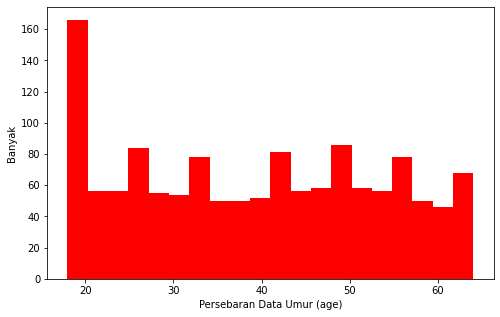

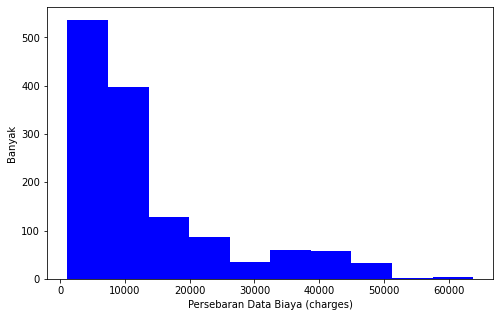

In [45]:
data_age = data.select('age')
data_charges = data.select('charges')

fig, axes = plt.subplots()
fig.set_size_inches(8, 5)
hist(axes, data_age, bins=20, color="red")
plt.xlabel('Persebaran Data Umur (age)')
plt.ylabel('Banyak')

fig, axes = plt.subplots()
fig.set_size_inches(8, 5)
hist(axes, data_charges, color="blue")
plt.xlabel('Persebaran Data Biaya (charges)')
plt.ylabel('Banyak')

plt.show()

Pada persebaran **data umur (age)** tidak terdapat outlier, karena umur pasti lebih dari 0 dan umur maksimal adalah 64, umur minimal 18, jadi umur yang adalah **18 < umur < 64**

Pada data persebaran **biaya asuransi (charges)** tidak terdapat outlier, dan biaya terkecil asuransi tersebut adalah 1121.8739 dan biaya terbesar asuransi tersebut adalah 63770.42801 

**Cek apakah adat data yang kosong (null)**

In [46]:
table = ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

for kolom in table:
  print('jumlah data yang bernilai null pada colom ', kolom, ' : ', data.where(col(kolom).isNull()).count())

jumlah data yang bernilai null pada colom  age  :  0
jumlah data yang bernilai null pada colom  sex  :  0
jumlah data yang bernilai null pada colom  bmi  :  0
jumlah data yang bernilai null pada colom  children  :  0
jumlah data yang bernilai null pada colom  smoker  :  0
jumlah data yang bernilai null pada colom  region  :  0
jumlah data yang bernilai null pada colom  charges  :  0


Pada dataset tersebut tidak terdapat data yang kosong/null.

## **2. PRE PROCESSING**

## **3. PEMROSESAN DATA**

Pada pemrosesan data ini akan dianalisis perbandingan rata-rata biaya asuransi kesehatan berdasarkan jenis kelamin dan perilaku merokok

**3.1 Perbandingan rata-rata biaya asuransi kesehatan berdasarkan jenis kelamin**

In [143]:
# membuat tabel
data.createOrReplaceTempView("dataAsuransi")

# seleksi data perempuan
data_asuransi_perempuan = spark.sql("SELECT * FROM dataAsuransi WHERE sex = 'female'")

# seleksi data laki-laki
data_asuransi_lakilaki = spark.sql("SELECT * FROM dataAsuransi WHERE sex = 'male'")

# tampilkan data
print("Jumlah data pengguna asuransi kesehatan berjenis kelamin perempuan", data_asuransi_perempuan.count())
print('10 data teratas biaya asuransi kesehatan perempuan')
data_asuransi_perempuan.show(10)

print("Jumlah data pengguna asuransi kesehatan berjenis kelamin laki-laki", data_asuransi_lakilaki.count())
print('10 data teratas biaya asuransi kesehatan laki-laki')
data_asuransi_lakilaki.show(10)

# hitung rata-rata biaya asuransi kesehatan berdasarkan jenis kelamin
rata_rata_biaya_jk = spark.sql("SELECT sex, AVG(charges) FROM dataAsuransi GROUP BY sex")
rata_rata_biaya_jk.show()

# ambil data single value dari spark sql
rata_biaya_pr = rata_rata_biaya_jk.collect()[0][1]
rata_biaya_lk = rata_rata_biaya_jk.collect()[1][1]

Jumlah data pengguna asuransi kesehatan berjenis kelamin perempuan 662
10 data teratas biaya asuransi kesehatan perempuan
+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
| 62|female| 26.29|       0|   yes|southeast| 27808.7251|
| 56|female| 39.82|       0|    no|southeast| 11090.7178|
| 52|female| 30.78|       1|    no|northeast| 10797.3362|
| 60|female|36.005|       0|    no|northeast|13228.84695|
| 30|female|  32.4|       1|    no|southwest|   4149.736|
+---+------+------+--------+------+---------+-----------+
only showing top 10 rows

Jumlah data pengguna asuransi kesehatan 

Pada data tersebut telah dilakukan pemrosesan data berupa seleksi pengguna asuransi kesehatan berdasarkan jenis kelamin, yaitu laki-laki dan perempuan. Hasil tersebut didapat banyak pengguna asuransi kesehatan berjenis kelamin perempuan sebanyak **662** dan pengguna asuransi kesehatan berjenis kelamin laki-laki sebanyak **676**.

Lalu dilakukan pemrosesan data berupa perhitungan rata-rata biaya asuransi kesehatan berdasarkan jenis kelamin. Didapat hasil rata-rata biaya asuransi kesehatan perempuan adalah : **12569.57884383534**, sedangkan untuk laki-laki adalah : **13956.751177721886**

**3.2 Perbandingan rata-rata biaya asuransi kesehatan berdasarkan perilaku merokok**

In [183]:
# pada pemrosesan data ini menggunakan transformasi dan action pada spark dataframe

# filter data pengguna asuransi yang merokok
pengguna_asuransi_perokok = data.filter(data.smoker == 'yes')

# filter data pengguna asuransi yang tidak merokok
pengguna_asuransi_bukan_perokok = data.filter(data.smoker == 'no')

# hitung rata-rata biaya asuransi kesehatan berdasarkan perilaku merokok
rata_biaya_berdasarkan_perokok = data.groupby('smoker').avg('charges')

# ambil data single value dari spark dataframe
rata_biaya_perokok = rata_biaya_berdasarkan_perokok.collect()[1][1]
rata_biaya_bukan_perokok = rata_biaya_berdasarkan_perokok.collect()[0][1]

print("Jumlah pengguna asuransi yang merokok       : ", pengguna_asuransi_perokok.count())
print("Jumlah pengguna asuransi yang bukan perokok : ", pengguna_asuransi_bukan_perokok.count())

print('\n\n')

print("5 data teratas pengguna asuransi yang merokok")
pengguna_asuransi_perokok.show(5)

print('\n')

print("5 data teratas pengguna asuransi yang tidak merokok")
pengguna_asuransi_bukan_perokok.show(5)

print('\n')

print("perbandingan rata-rata biaya asuransi berdasarkan perilaku merokok")
rata_biaya_berdasarkan_perokok.show()

Jumlah pengguna asuransi yang merokok       :  274
Jumlah pengguna asuransi yang bukan perokok :  1064



5 data teratas pengguna asuransi yang merokok
+---+------+-----+--------+------+---------+----------+
|age|   sex|  bmi|children|smoker|   region|   charges|
+---+------+-----+--------+------+---------+----------+
| 19|female| 27.9|       0|   yes|southwest| 16884.924|
| 62|female|26.29|       0|   yes|southeast|27808.7251|
| 27|  male|42.13|       0|   yes|southeast|39611.7577|
| 30|  male| 35.3|       0|   yes|southwest| 36837.467|
| 34|female|31.92|       1|   yes|northeast|37701.8768|
+---+------+-----+--------+------+---------+----------+
only showing top 5 rows



5 data teratas pengguna asuransi yang tidak merokok
+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    n

Pada data tersebut telah dilakukan pemrosesan data berupa seleksi pengguna asuransi kesehatan berdasarkan perilaku merokok. Hasil tersebut didapat banyak pengguna asuransi kesehatan yang merokok sebanyak **274** dan pengguna asuransi kesehatan yang tidak merokok sebanyak **1064**.

Lalu dilakukan pemrosesan data berupa perhitungan rata-rata biaya asuransi kesehatan berdasarkan perilaku merokok. Didapat hasil rata-rata biaya asuransi kesehatan untuk orang yang merokok adalah : **32050.23183153285**, sedangkan untuk orang yang tidak merokok adalah : 32050.23183153285

## **4. VISUALISASI DATA**

visualisasi data kali ini menggunakan library matplotlib, menggunakan grafis bar.

Data yang akan divisulisasi yaitu rata-rata biaya asuransi kesehatan berdasarkan jenis kelamin, berdasarkan perilaku merokok dan keduanya.

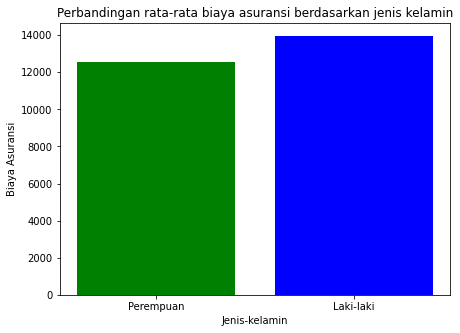

In [178]:
# plotting data 

# rata-rata biaya asuransi kesehatan berdasarkan jenis kelamin
fig, axes = plt.subplots()

plt.title('Perbandingan rata-rata biaya asuransi berdasarkan jenis kelamin')
plt.bar('Perempuan', rata_biaya_pr, color='g')
plt.bar('Laki-laki', rata_biaya_lk, color='b')
plt.xlabel('Jenis-kelamin')
plt.ylabel('Biaya Asuransi')
fig.set_size_inches(7, 5)

print('\n')

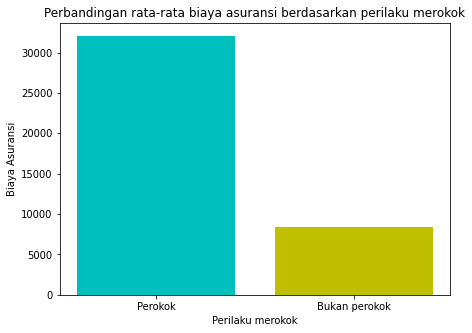

In [188]:
# plotting data 

# rata-rata biaya asuransi kesehatan berdasarkan perilaku merokok
# rata_rata_biaya_pr.collect()
fig, axes = plt.subplots()

plt.title('Perbandingan rata-rata biaya asuransi berdasarkan perilaku merokok')
plt.bar('Perokok', rata_biaya_perokok, color='c')
plt.bar('Bukan perokok', rata_biaya_bukan_perokok, color='y')
plt.xlabel('Perilaku merokok')
plt.ylabel('Biaya Asuransi')
fig.set_size_inches(7, 5)

print('\n')